In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch.optim as optim

import prettytable
import time
sys.setrecursionlimit(15000)
from thop.profile import profile

from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import seaborn as sns

from utils import ImageShow,draw_size_acc,one_hot
from utils import confusion_matrix,metrics_scores
from model import FixCapsNet

In [3]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "HAM10000"#"COVID-19"#"ISIC2019"#"skin_lesion"#
best_acc = 0.
eval_acc = 0.
best_train = 0.
#defined 
try:
    print(len(train_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list = train_loss_list,
                 train_acc_list = train_acc_list,
                test_loss_list = test_loss_list,
                test_acc_list = test_acc_list,
                test_auc_list = test_auc_list,
                val_loss_list = val_loss_list,
                val_acc_list = val_acc_list,
                )

In [4]:
def get_data(trans_size='308'):
    global test_dataset,train_loader,val_loader,test_loader,train_num,val_num,test_num,n_classes,cla_dict
    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop((299, 299)),
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "val": transforms.Compose([transforms.Resize((308, 308)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ]),
        "test": transforms.Compose([transforms.Resize((trans_size, trans_size)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])
        }

    data_root = os.path.abspath(os.path.join(os.getcwd()))  # get data root path
    image_path = os.path.join(data_root, "datasets","HAM10000")#
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path,train_doc),#
                                         transform=data_transform["train"])
    val_dataset = datasets.ImageFolder(root=os.path.join(image_path,val_doc),
                                            transform=data_transform["val"])
    test_dataset = datasets.ImageFolder(root=os.path.join(image_path,test_doc),
                                            transform=data_transform["test"])

    train_num = len(train_dataset)
    val_num = len(val_dataset)
    test_num = len(test_dataset)

    data_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in data_list.items())
    n_classes  = len(data_list)
    print(f'Using {n_classes } classes.')
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open(f'{img_title}.json', 'w') as json_file:#class_indices
        json_file.write(json_str)

    pin_memory = True
    train_loader = DataLoader(train_dataset,batch_size=BatchSize,
                                               pin_memory=pin_memory,
                                               shuffle=True,num_workers=nw)
    val_loader = DataLoader(val_dataset,batch_size=V_size,
                                               pin_memory=pin_memory,
                                               shuffle=False,num_workers=nw)
    test_loader = DataLoader(test_dataset,batch_size=T_size,
                                              pin_memory=pin_memory,
                                              shuffle=False,num_workers=nw)

    print("using {} images for training, {} images for validation, {} images for testing.".format(train_num,
                                                                                                  val_num,
                                                                                                  test_num))

In [5]:
BatchSize = 128#128#188
V_size = 31
T_size = 31
learning_rate = 0.123
train_doc = "train525e384png"
val_doc = "val525e384png"
test_doc = "test525png384"
nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 4]) 
print(f'Using {nw} dataloader workers every process.')
get_data()

Using 4 dataloader workers every process.
Using 7 classes.
using 52911 images for training, 1006 images for validation, 828 images for testing.


In [6]:
# Create capsule network.
n_channels = 3
conv_outputs = 128 #Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6  # fixme get from conv2d
output_unit_size = 16
img_size = 299
mode='DS'
network = FixCapsNet(conv_inputs=n_channels,
                     conv_outputs=conv_outputs,
                     primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     num_classes=n_classes,
                     output_unit_size=16,
                     init_weights=True,
                     mode=mode)
network = network.to(device)
summary(network,(n_channels,img_size,img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 141, 141]             972
            Conv2d-2          [-1, 128, 71, 71]             384
       BatchNorm2d-3          [-1, 128, 71, 71]             256
              ReLU-4          [-1, 128, 71, 71]               0
FractionalMaxPool2d-5          [-1, 128, 20, 20]               0
            Conv2d-6          [-1, 128, 20, 20]          16,384
       BatchNorm2d-7          [-1, 128, 20, 20]             256
         Hardswish-8          [-1, 128, 20, 20]               0
 AdaptiveAvgPool2d-9            [-1, 128, 1, 1]               0
           Conv2d-10            [-1, 128, 1, 1]          16,512
             ReLU-11            [-1, 128, 1, 1]               0
           Conv2d-12            [-1, 128, 1, 1]          16,512
AdaptiveMaxPool2d-13            [-1, 128, 1, 1]               0
           Conv2d-14            [-1, 1

In [7]:
print("%s | %s | %s" % ("Model", "Params(M)", "FLOPs(G)"))
print("---|---|---")
name = "FixCaps"
dsize = (1, 3, 299, 299)
inputs = torch.randn(dsize).to(device)
total_ops, total_params = profile(network, (inputs,), verbose=False)
print(
    "%s | %.2f | %.2f" % (name, total_params / (1000 ** 2), total_ops / (1000 ** 3))
    )
#FLOPs(G)--> 0.07(0.08).

Model | Params(M) | FLOPs(G)
---|---|---
FixCaps | 0.13 | 0.03


In [8]:
network.Convolution

Sequential(
  (0): Conv2d(3, 3, kernel_size=(18, 18), stride=(2, 2), groups=3, bias=False)
  (1): Conv2d(3, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): FractionalMaxPool2d()
)

In [9]:
def train(epoch):
    network.train()
    global best_train,train_evl_result#,evl_tmp_result
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    steps_num = len(train_loader)
    tmp_size = BatchSize
    print(f'\033[1;32m[Train Epoch:[{epoch}]{img_title} ==> Training]\033[0m ...')
    optimizer.zero_grad()
    train_tmp_result = torch.zeros(n_classes,n_classes)
    # scaler = torch.cuda.amp.GradScaler()
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):        

        batch_idx += 1
        target_indices = target
        target_one_hot = one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)
        # data, target =data.to(device), target_one_hot.to(device)
        # with torch.cuda.amp.autocast():
        output = network(data)
        loss = network.loss(output, target, size_average=True)       
        loss.backward()
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()        
        optimizer.step()
        optimizer.zero_grad()
        # scheduler.step()#AdamW            
        running_loss += loss.item()
        
        v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        tmp_pre = r_pre/(batch_idx*BatchSize)
        
        if batch_idx % print_step == 0:
            print("[{}/{}] Loss{:.5f},ACC:{:.5f}".format(batch_idx,len(train_loader),
                                                         loss,tmp_pre))
        if batch_idx % steps_num == 0 and train_num % tmp_size != 0:
            tmp_size = train_num % tmp_size
                          
        for i in range(tmp_size):
            pred_x = pred.numpy()
            train_tmp_result[target_indices[i]][pred_x[i]] +=1

        if best_train < tmp_pre and tmp_pre >= 80:
            torch.save(network.state_dict(), iter_path)
        
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)  
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc) 
    scheduler.step()
    if best_train < epoch_acc:
        best_train = epoch_acc
        train_evl_result = train_tmp_result.clone()
        torch.save(network.state_dict(), last_path)
        torch.save(train_evl_result, f'./tmp/{img_title}/{suf}/train_evl_result.pth')
    
    print("Train Epoch:[{}] Loss:{:.5f},Acc:{:.5f},Best_train:{:.5f}".format(epoch,epoch_loss,
                                                                     epoch_acc,best_train))

In [10]:
def test(split="test"):
    network.eval()
    global test_acc,eval_acc,best_acc,test_evl_result,val_evl_result,evl_tmp_result,net_parameters
    cor_loss,correct,Auc, Acc= 0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    
    if split == 'val':
        data_loader = val_loader
        tmp_size = V_size
        data_num = val_num
    else:
        data_loader = test_loader
        tmp_size = T_size
        data_num = test_num
        
    steps_num = len(data_loader)
    print(f'\033[35m{img_title} ==> {split} ...\033[0m')
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
            batch_idx +=1
            target_indices = target#torch.Size([batch, 7])  
            target_one_hot = one_hot(target, length=n_classes)            
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

            output= network(data)#torch.Size([batch_size, 7, 16, 1])         
            v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True))
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]
            
            if batch_idx % steps_num == 0 and test_num % tmp_size != 0:
                tmp_size = data_num % tmp_size
                          
            for i in range(tmp_size):
                pred_y = pred.numpy()
                evl_tmp_result[target_indices[i]][pred_y[i]] +=1 

    diag_sum = torch.sum(evl_tmp_result.diagonal())
    all_sum = torch.sum(evl_tmp_result) 
    test_acc = 100. * float(torch.div(diag_sum,all_sum)) 
    print(f"{split}_Acc:\033[1;32m{round(float(test_acc),3)}%\033[0m")
    
    if split == 'val':
        val_acc_list.append(test_acc)
        if test_acc > best_acc:
            best_acc = test_acc
            val_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
            torch.save(network.state_dict(), save_PATH)
            torch.save(val_evl_result, f'./tmp/{img_title}/{suf}/best_evl_result.pth')
        print(f"Best_val:\033[1;32m[{round(float(best_acc),3)}%]\033[0m")
    else:
        test_acc_list.append(test_acc)
        if test_acc > eval_acc:
            eval_acc = test_acc
            test_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
            torch.save(network.state_dict(), f'./tmp/{img_title}/{suf}/{split}_best_{img_title}_{suf}.pth')
            torch.save(test_evl_result, f'./tmp/{img_title}/{suf}/{split}_evl_result.pth')
        print(f"Best_eval:\033[1;32m[{round(float(eval_acc),3)}%]\033[0m")  

In [11]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf:{suf}")   
if os.path.exists(f'./tmp/{img_title}/{suf}'):
    print (f'Store: "./tmp/{img_title}/{suf}"')
else:
    os.mkdir(f"./tmp/{img_title}/{suf}")
iter_path = f'./tmp/{img_title}/{suf}/train_{img_title}_{suf}.pth'
save_PATH = f'./tmp/{img_title}/{suf}/best_{img_title}_{suf}.pth'
last_path = f'./tmp/{img_title}/{suf}/last_{img_title}_{suf}.pth'
print(save_PATH)

suf:0624_234723
./tmp/HAM10000/0624_234723/best_HAM10000_0624_234723.pth


In [12]:
num_epochs = 125

In [13]:
# learning_rate = 0.123
def_betas=(0.9, 0.999)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
# optimizer = optim.AdamW(network.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)

#base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0,
# scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate,
#                         steps_per_epoch=len(train_loader),
#                         epochs=num_epochs)

In [ ]:
for epoch in range(1, num_epochs + 1): 
    train(epoch)
    test('val')

print('Finished Training')

[Train Epoch:[1]HAM10000 ==> Training] ...


  0%|          | 0/414 [00:00<?, ?it/s]

In [86]:
network.load_state_dict(torch.load(save_PATH))
dict_size ={}
dict_test = {}
for j in range(21,31):
    print(f"size:{j}")
    T_size = j

    for i in range(300,325):      
        get_data(i)
        for k in range(5):
            test()
            if dict_test.get(i) is None or dict_test[i] < test_acc:
                dict_test[i] = test_acc
                
                if dict_size.get(j) is None or dict_size[j] < test_acc:
                    dict_size[j] = test_acc
                    
            elif dict_size.get(j) is None or dict_size[j] < test_acc:
                    dict_size[j] = test_acc

size:24
Using 7 classes.
using 52911 images for training, 1006 images for validation, 828 images for testing.
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.082%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[95.894%]
Using 7 classes.
using 52911 images for training, 1006 images for validation, 828 images for testing.
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[95.894%]
Using 7 classes.
using 52911 images for training, 1006 images for validation, 828 images for testing.
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[95.894%]
Using 7 classes.
using 52911 images for training, 1006 images for validation, 828 images for testing.
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[95.894%]
size:25
Using 7 classes.
using 52911 images for training, 1006 images for validation, 828 images for testing.
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[95.894%]
Using 7 classes.
using 52911 images for training, 1006 images for validation, 828 images for testing.
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.894%]
Using 7 classes.
using 52911 images for training, 1006 images for validation, 828 images for testing.
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.565%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[95.894%]
Using 7 classes.
using 52911 images for training, 1006 images for validation, 828 images for testing.
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.894%]


In [89]:
show.conclusion(img_title=img_title)
sorted(dict_size.items(), key=lambda x: x[1], reverse=True)[0:9]

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [3788]
[Test] ACC:95.89%.


[(25, 95.89372277259827), (24, 95.41062712669373)]

In [90]:
sorted(dict_test.items(), key=lambda x: x[1], reverse=True)[0:9]

[(302, 95.89372277259827),
 (300, 95.41062712669373),
 (303, 95.28985619544983),
 (301, 95.16907930374146)]

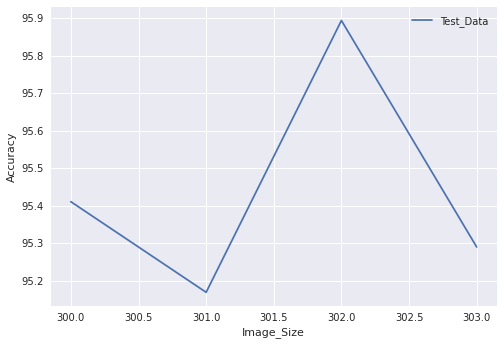

In [91]:
draw_size_acc(dict_test,custom_path='./tmp',img_title=img_title,suf=suf)

In [74]:
metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |    0.8    |  0.87  | 0.833 |          |
|  bcc   |    0.88   | 0.846  | 0.863 |          |
|  bkl   |   0.8939  | 0.894  | 0.894 |          |
|   df   |    0.5    |  0.5   |  0.5  |          |
|  mel   |   0.9565  | 0.647  | 0.772 |          |
|   nv   |   0.9792  | 0.992  | 0.986 |          |
|  vasc  |   0.9091  |  1.0   | 0.952 |          |
| Total: |           |        |       |  0.9589  |
+--------+-----------+--------+-------+----------+


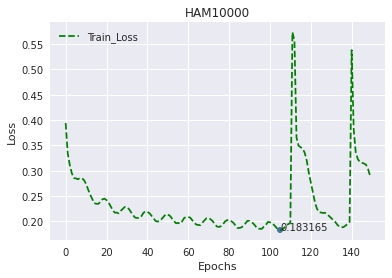

In [26]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

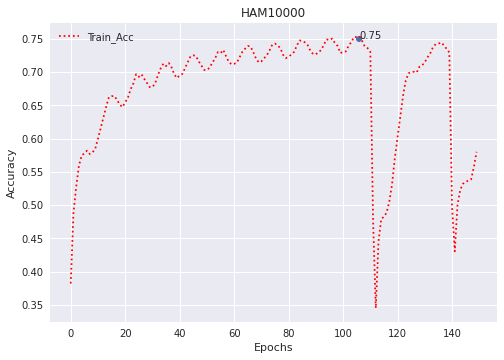

In [27]:
show.train(opt='Acc',write=True,custom_path='./tmp',img_title=img_title,suf=suf)

In [29]:
# #save
s0 = np.array(train_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_acc_{suf}.npy', s0)
s1 = np.array(train_loss_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_loss_{suf}.npy', s1)
s2 = np.array(val_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_val_acc_{suf}.npy', s2)
s3 = np.array(test_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_test_acc_{suf}.npy', s2)

In [30]:
torch.cuda.memory.empty_cache()

In [69]:
# network.load_state_dict(torch.load(save_PATH))
# dict_batch ={}
# dict_img = {}
# for j in range(24,26):
#     print(f"size:{j}")
#     T_size = j

#     for i in range(300,304):      
#         get_data(i)
#         for k in range(5):
#             test()
#             if dict_img.get(i) is None or dict_img[i] < test_acc:
#                 dict_img[i] = test_acc
                
#                 if dict_batch.get(j) is None or dict_batch[j] < test_acc:
#                     dict_batch[j] = test_acc

size:24
Using 7 classes.
using 52911 images for training, 1006 images for validation, 828 images for testing.
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.652%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[95.652%]
Using 7 classes.
using 52911 images for training, 1006 images for validation, 828 images for testing.
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:93.961%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.652%]
Using 7 classes.
using 52911 images for training, 1006 images for validation, 828 images for testing.
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.29%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[95.652%]
Using 7 classes.
using 52911 images for training, 1006 images for validation, 828 images for testing.
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/35 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[95.652%]
size:25
Using 7 classes.
using 52911 images for training, 1006 images for validation, 828 images for testing.
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.807%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.652%]
Using 7 classes.
using 52911 images for training, 1006 images for validation, 828 images for testing.
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.686%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[95.652%]
Using 7 classes.
using 52911 images for training, 1006 images for validation, 828 images for testing.
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.928%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.203%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.048%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.444%
Best_eval:[95.652%]
Using 7 classes.
using 52911 images for training, 1006 images for validation, 828 images for testing.
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.169%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.411%
Best_eval:[95.652%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:95.894%
Best_eval:[95.894%]
HAM10000 ==> test ...


  0%|          | 0/34 [00:00<?, ?it/s]

test_Acc:94.324%
Best_eval:[95.894%]


In [72]:
# show.conclusion(img_title=img_title)
# sorted(dict_batch.items(), key=lambda x: x[1], reverse=True)[0:9]

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [3788]
[Test] ACC:95.89%.


[(25, 95.89372277259827), (24, 95.652174949646)]

In [73]:
# sorted(dict_img.items(), key=lambda x: x[1], reverse=True)[0:9]

[(303, 95.89372277259827),
 (300, 95.652174949646),
 (302, 95.28985619544983),
 (301, 95.16907930374146)]

In [ ]:
# show.conclusion(img_title=img_title)
# sorted(test_dict.items(), key=lambda x: x[1], reverse=True)[0:9]

In [92]:
metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
| akiec  |    0.8    |  0.87  | 0.833 |          |
|  bcc   |    0.88   | 0.846  | 0.863 |          |
|  bkl   |   0.8939  | 0.894  | 0.894 |          |
|   df   |    0.5    |  0.5   |  0.5  |          |
|  mel   |   0.9565  | 0.647  | 0.772 |          |
|   nv   |   0.9792  | 0.992  | 0.986 |          |
|  vasc  |   0.9091  |  1.0   | 0.952 |          |
| Total: |           |        |       |  0.9589  |
+--------+-----------+--------+-------+----------+


In [ ]:
# confusion_matrix(test_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=suf)